# Access Policy Evaluation Logic

## Access policy evaluation logic

Identity-based policies and resource-based policies grant permissions to the identities or resources to which they are attached. When an IAM entity (user or role) requests access to a resource in the same account, AWS evaluates all the permissions granted by the identity-based and resource-based policies. The resulting permission set is the total accumulated permissions from the two policy types. AWS evaluates all policies associated with a resource and builds a compilation of access rights into a key-value file called the request context.

If an action is allowed by an identity-based policy, a resource-based policy, or both, AWS allows the action. An explicit deny in either of these policies overrides the allow.

## Operation logic
When Amazon S3 receives a request, it first verifies that the requester has the necessary permissions. Amazon S3 evaluates all the relevant access policies in deciding whether to authorize the request. These policies can include access point policies, user policies, and resource-based policies (bucket policy, bucket ACL, object ACL).

To determine whether the requester has permission to perform the specific operation, Amazon S3 converts all applicable policies and combines them into a key-value file called a request context. It then evaluates this set of policies in the following order:

### Step 1

**User context**
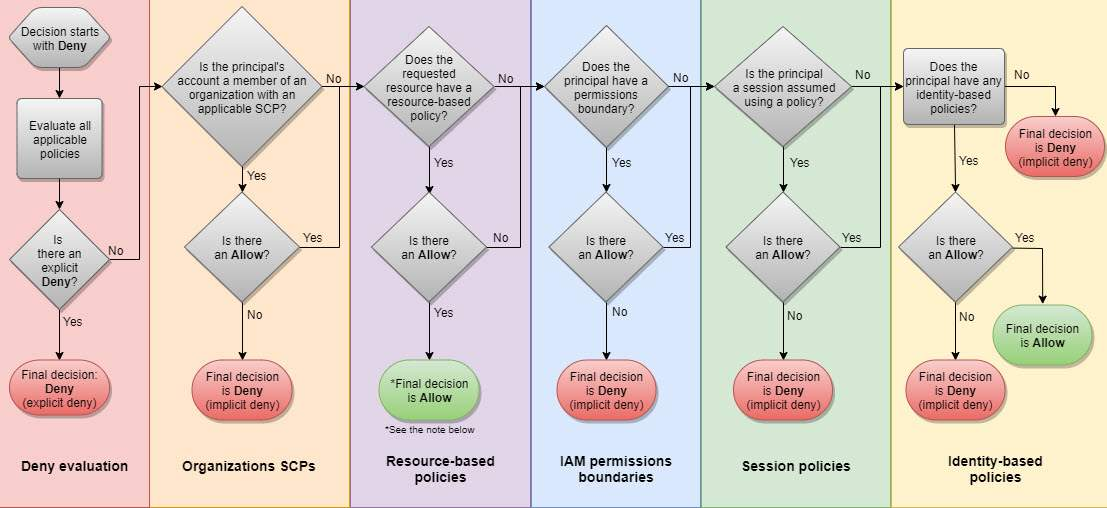

Amazon S3 evaluates a subset of policies owned by the parent account. This subset includes the user policy that the parent attaches to the user. If the parent also owns the resource in the request (bucket, object), Amazon S3 also evaluates the corresponding resource policies (bucket policy, bucket ACL, and object ACL) at the same time. A user must have permission from the parent account to perform the operation. This step applies only if the request is made by a user in an AWS account. If the request is made by AWS account root users, Amazon S3 skips this step.

The flow chart provides details about how the decision is made.

### Step 2

**Bucket context**
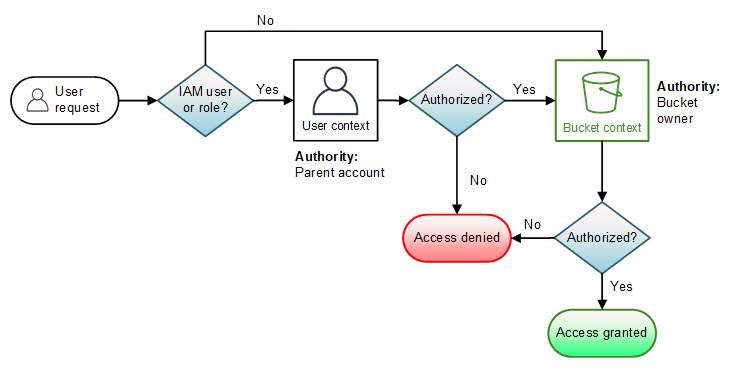

This caption shows the user logic for determining bucket access when comparing IAM policies
If the request is for a bucket operation, the requester must have permission from the bucket owner. If the request is for an object, Amazon S3 evaluates all the policies owned by the bucket owner to check whether the bucket owner has explicitly denied access to the object. If there is an explicit deny set, Amazon S3 does not authorize the request.

The diagram illustrates the context-based evaluation for bucket operation.

### Step 3

**Object context**
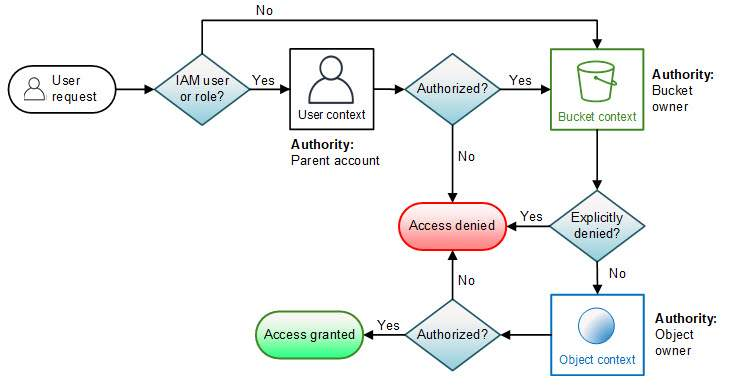

This caption is a flow chart of the AWS access logic used to determine access to an object within the S3 buckets
If the request is for an object, Amazon S3 evaluates the subset of policies owned by the object owner.

The diagram illustrates the context-based evaluation for object operation.

## Demo: Example of modified IAM policy

Below is the modified IAM policy, from the demonstration, allowing Jane access to the /private folder.

``` {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ViewS3bucketsInConsole",
            "Effect": "Allow",
            "Action": [
                "s3:ListAllMyBuckets",
                "s3:GetBucketLocation"
            ],
            "Resource": "arn:aws:s3:::*"
        },
        {
            "Sid": "AllowRootFileview",
            "Effect": "Allow",
            "Action": "s3:ListBucket",
            "Resource": "arn:aws:s3:::healthcare-sales1",
            "Condition": {
                "StringEquals": {
                    "s3:prefix": [
                        "",
                        "goals/",
                        "private/"
                    ]
                }
            }
        },
        {
            "Sid": "ReadWriteAccess",
            "Effect": "Allow",
            "Action": [
                "s3:PutObject",
                "s3:GetObject"
            ],
            "Resource": "arn:aws:s3:::healthcare-sales1/goals/*"
        },
        {
            "Sid": "ReadWriteDelete",
            "Effect": "Allow",
            "Action": [
                "s3:PutObject",
                "s3:GetObject",
                "s3:DeleteObject"
            ],
            "Resource": "arn:aws:s3:::healthcare-sales1/private/*"
        }
    ]
}
 ```

### Demo: Example of group policy using an explicit deny

Below is the modified IAM policy, from the demonstration, denying the group access to the /private folder.

``` {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ViewS3bucketsInConsole",
            "Effect": "Allow",
            "Action": [
                "s3:ListAllMyBuckets"
            ],
            "Resource": "arn:aws:s3:::*"
        },
        {
            "Sid": "ExplictDenyAccessToPrivateFolderToEveryoneInTheGroup",
            "Action": [
                "s3:*"
            ],
            "Effect": "Deny",
            "Resource": [
                "arn:aws:s3:::healthcare-sales1/private/*"
            ]
        },
        {
            "Sid": "DenyListBucketOnPrivateFolder",
            "Action": [
                "s3:ListBucket"
            ],
            "Effect": "Deny",
            "Resource": [
                "arn:aws:s3:::healthcare-sales1"
            ],
            "Condition": {
                "StringLike": {
                    "s3:prefix": [
                        "private/"
                    ]
                }
            }
        }
    ]
}
 ```

## Amazon S3 Object Ownership

Historically, an Amazon S3 object was owned by the AWS account that uploaded the object. If a bucket owner uploaded an object, the bucket owner remained the owner of that object. If another AWS account uploaded objects to your bucket, the AWS account that uploaded them remained the owner of those objects. 

With the Amazon S3 Object Ownership feature, the bucket owner owns all objects written to the bucket. The bucket owner has full control of the objects and automatically owns any new objects written by other accounts.

Amazon S3 Object Ownership has two modes, as illustrated in the following figure:

1. Object writer – The account that is writing the object owns the object.
2. Bucket owner preferred – The bucket owner owns the object if the object is uploaded with the bucket-owner-full-control canned ACL (a set of predefined ACLs). Without this setting and canned ACL, the object is uploaded to the bucket but the uploading account remains the owner.

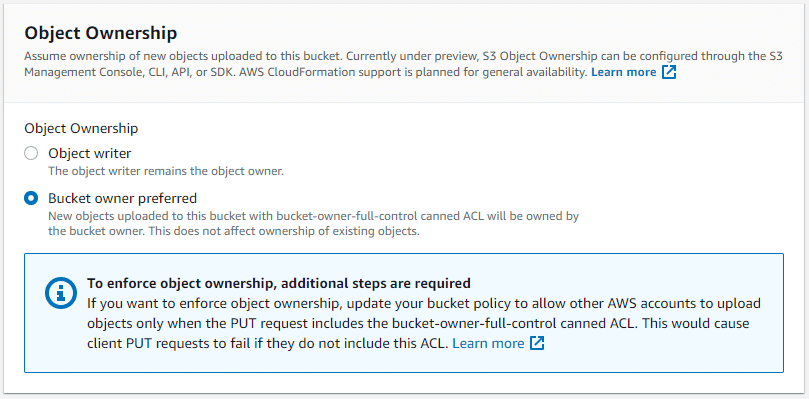







## Enforcing S3 Object Ownership

After you set the S3 Object Ownership to Bucket owner preferred, you can add a bucket policy to require all Amazon S3 PUT operations to include the bucket-owner-full-control canned ACL. If the uploader fails to meet the ACL requirement in their upload, the request fails. This setting enables bucket owners to enforce uniform object ownership across all newly uploaded objects in their buckets. 